**Title: Air Quality Forecasting using Time Series Machine Learning Models
Objective**

The objective of this project assignment is to develop a machine learning model that predicts future air quality levels based on historical air quality data and relevant environmental factors. Students will gain practical experience in time series analysis, feature engineering, model selection, and evaluation for air quality forecasting.

A few years ago, China established the Air Quality Index (AQI) based on the level of five pollutants atmospheres, namely sulfur dioxide (SO2), nitrogen dioxide (NO2), particulate matter (PM10), carbon monoxide (CO) and ozone (O3) measured at the monitoring stations in each city. 

The dataset consists of hourly atmospheric measurements from 12 cities in Beijing, covering the period from March 1st, 2013, to February 28th, 2017. The target variables are PM2.5, PM10, SO2, NO2, CO, and O3, along with independent variables like temperature, pressure, dew point temperature, rainfall, wind speed, and wind direction.
Requirements


### 00. setup

1. import libraries

In [404]:
import pandas as pd
import numpy as np
import arff
from scipy.io import arff
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler, RobustScaler
from statsmodels.tsa.stattools import adfuller # ADF test/stationarity test
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# custom imports
import sys # to import from utils folder
sys.path.append("/home/dataopske/Desktop/machine-learning-ii/mercedes_benz_dimensiionaility reduction/utils") # path to utils folder
from kde_plt import kde_plt_grid # custom kde plot function from utils folder

2. import data

- convert the arff to csv for easy analysis

In [273]:
# dataset = arff.load(open('dataset.arff'))
# df = pd.DataFrame(dataset['data'], columns=[a[0] for a in dataset['attributes']])
# df.to_csv("dataset.csv", index=False)

In [293]:
df = pd.read_csv("dataset.csv")

3. quick look at the data

In [294]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [295]:
df.shape

(420768, 18)

In [296]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

### a. data preprocessing

- i'll use missingno to visualise missing data

<Axes: >

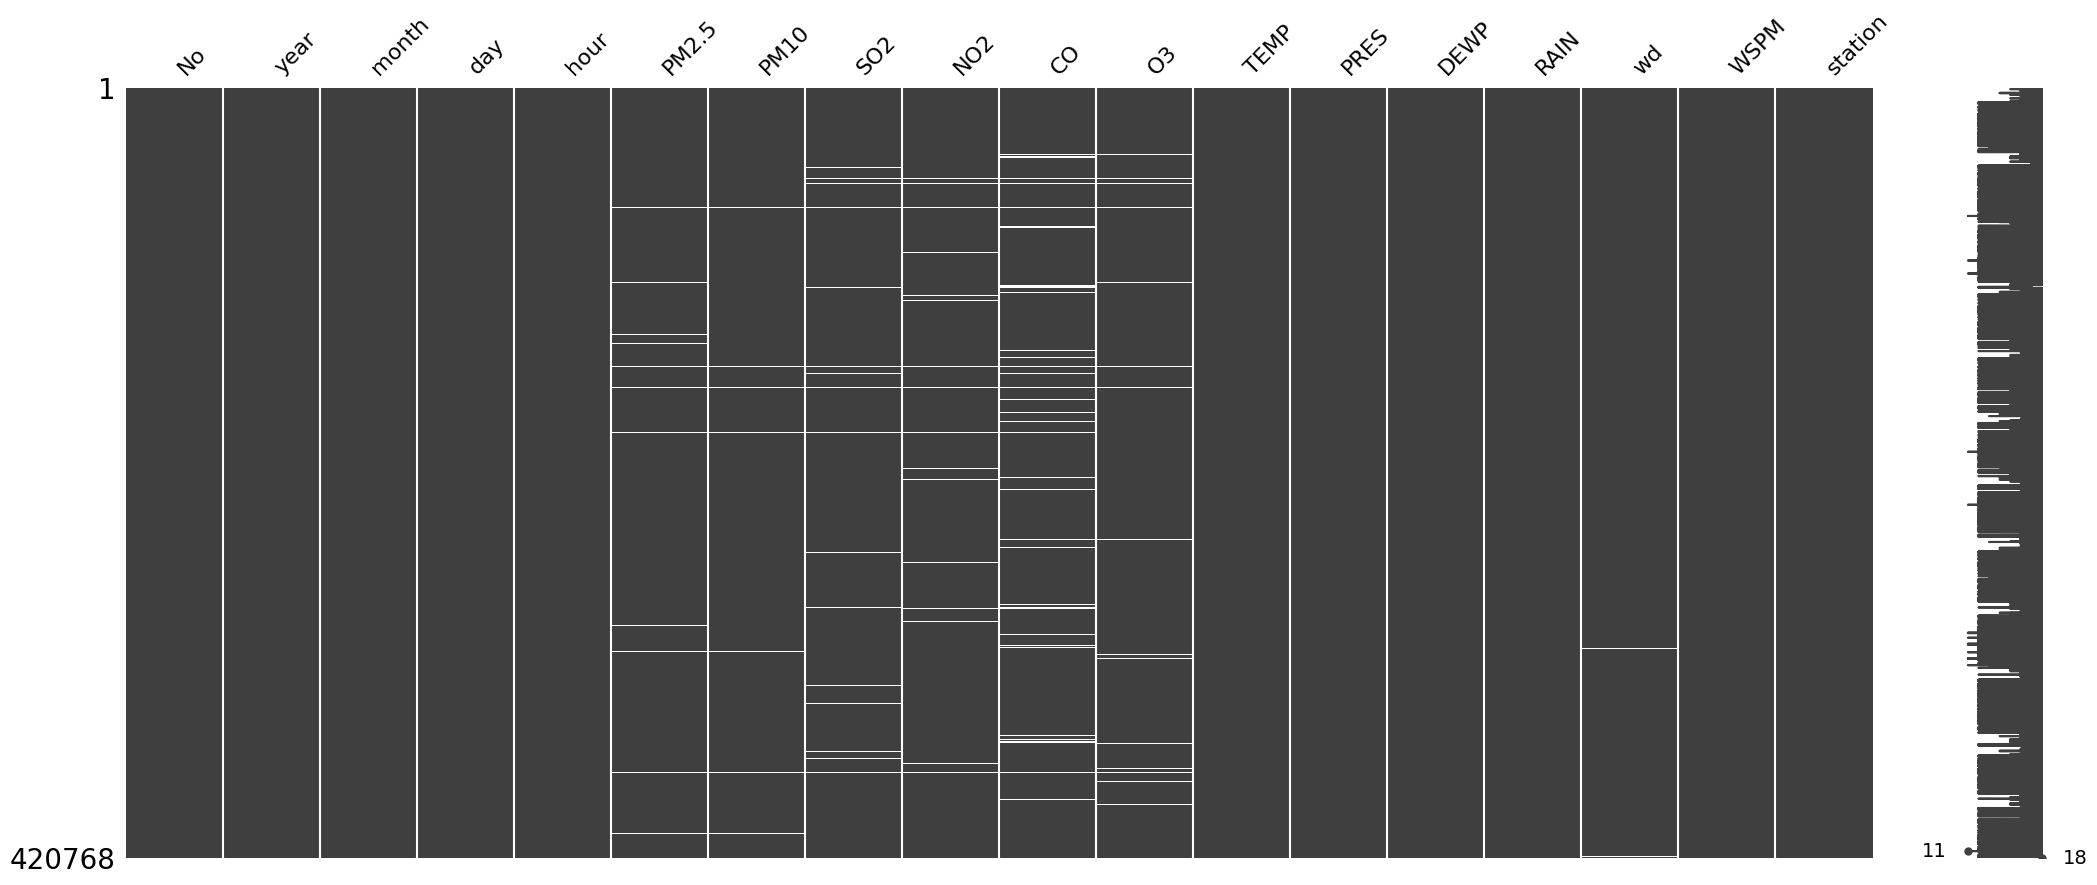

In [297]:
msno.matrix(df)

> there is missing data, there is also some correlation in the missing data

1. create a `datetime` column from `year, month, day, hour`

In [298]:
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

2. sort the df by `datetime` column

In [299]:
# sort the df by datetime
df = df.sort_values('datetime')

3. set `datetime` column as index

In [300]:
# set datetime as index
df.set_index('datetime', inplace=True, drop=True)

4. impute missing values in numeric columns by interpolation

In [301]:
# interpolate only numeric columns
df_numeric = df.select_dtypes(include=['float64','int64'])
df[df_numeric.columns] = df_numeric.interpolate(method='time')

# fill any remaining NaNs in categorical with forward fill
# Forward fill, then backward fill
df = df.ffill().bfill()

In [302]:
# Missing values
print(f'Total missing values: {df.isna().sum()}')

Total missing values: No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64


> now our data has no missing values

5. aggregate the df by day to reduce the number of rows

In [303]:
# resample to daily frequency ('D' = day) and compute the mean for all numeric columns
daily_means = df.resample('D').mean(numeric_only=True)

In [304]:
# aggregate non-numeric columns by taking the first value in each day
daily_means = df.resample('D').first(numeric_only=False)

In [305]:
daily_means.shape

(1461, 18)

> this has reduced the number of rows from 47k to 1461, this is much more manageable for time series analysis and forecasting

In [306]:
# drop redundant columns
# apparerently the drop in `df.set_index('datetime', inplace=True, drop=True)` does not drop these columns
daily_means.drop(['year','month','day','hour'], inplace=True, axis=1)

In [307]:
daily_means.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2013-03-01,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-02,25,4.0,7.0,3.0,2.0,200.0,74.0,-0.5,1027.4,-16.4,0.0,SW,3.0,Dingling
2013-03-03,49,77.0,93.0,69.0,106.0,1899.0,2.0,-1.4,1020.4,-13.0,0.0,NNE,1.2,Guanyuan
2013-03-04,73,13.0,34.0,3.0,34.0,200.0,76.0,9.2,1013.2,-12.6,0.0,ENE,2.4,Dingling
2013-03-05,97,70.0,102.0,57.0,90.0,1200.0,95.0,4.7,1015.2,-9.1,0.0,SW,1.6,Guanyuan


> amazing!

In [320]:
# Check for duplicate indices
print("Duplicate indices:", daily_means.index.duplicated().sum())
print("Total rows:", len(daily_means))

Duplicate indices: 0
Total rows: 1461


In [308]:
# mummary statistics
print(daily_means.describe())

                 No        PM2.5         PM10          SO2          NO2  \
count   1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean   17521.000000    86.752341   114.481513    14.752555    57.896557   
std    10125.568428    84.890359    96.614580    20.892272    37.522613   
min        1.000000     3.000000     3.000000     0.285600     1.231800   
25%     8761.000000    27.000000    43.000000     2.000000    29.000000   
50%    17521.000000    62.000000    91.000000     7.000000    51.000000   
75%    26281.000000   117.000000   159.000000    18.000000    81.000000   
max    35041.000000   549.000000   685.000000   197.000000   246.000000   

                CO           O3         TEMP         PRES         DEWP  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean   1378.635337    41.722044    11.258304  1011.142352     3.162188   
std    1332.293612    38.185996    10.716430    10.466974    13.644548   
min     100.000000     0.214

### b. scaling and transformation

1. **skewness:** a statistical measure that quantifies the asymmetry (lack of symmetry) in the distribution of a dataset's values around its mean. In a perfectly symmetric distribution (like a normal bell curve), skewness is 0.
- `|skew| < 0.5`: approximately symmetric.
- `0.5 < |skew| < 1`: moderately skewed.
- `|skew| > 1`: strongly skewed.
- `|skew| > 2–3`: highly/extremely skewed (often indicates heavy tails or outliers).

In [310]:
daily_means.skew(numeric_only=True)

No        0.000000
PM2.5     1.912744
PM10      1.700914
SO2       3.269811
NO2       0.926326
CO        2.520155
O3        0.878363
TEMP     -0.110788
PRES      0.121420
DEWP     -0.220519
RAIN     16.934560
WSPM      1.638018
dtype: float64

- `CO, PM2.5, PM10, SO2, WSPM` are strongly right skewed 
- `O3, NO2,` are moderatley skewed
- `RAIN` is extremely right skewed

2. **Kurtosis**: a statistical measure that describes the shape of a probability distribution's tails and peak relative to a normal distribution. it quantifies how much data clusters in the center (peakedness) and the heaviness of the tails (outliers). the standard kurtosis for a normal distribution is 3 (mesokurtic). most tools (like Pandas' kurtosis()) report excess kurtosis, which subtracts 3, so a normal distribution has excess kurtosis of 0.

- `Positive excess kurtosis (> 0)`: *Leptokurtic* – Sharper peak and heavier tails than normal. More extreme outliers (common in real-world data with rare events, like pollution spikes).
- `Negative excess kurtosis (< 0)`: *Platykurtic* – Flatter peak and lighter tails. Fewer outliers, more uniform spread.
- `Zero excess kurtosis (≈ 0)`: *Mesokurtic* – Similar to normal (balanced tails and peak).
Rough guidelines: 
`|kurtosis| < 0.5`: Near-normal;`0.5–3`: Moderately peaked/taily; `>3`: Highly leptokurtic (heavy outliers); extreme values like 10+ indicate very heavy tails.

- High kurtosis often pairs with skewness in environmental data, signaling non-normality that may require transformations for analysis.

In [311]:
daily_means.kurtosis(numeric_only=True)

No        -1.200000
PM2.5      4.547438
PM10       4.239450
SO2       15.381696
NO2        1.087074
CO         8.103449
O3         0.191721
TEMP      -1.301155
PRES      -0.866937
DEWP      -1.117821
RAIN     351.163896
WSPM       3.892057
dtype: float64

- RAIN's insane 351 suggests a wildly **outlier-prone** distribution (mostly dry days, occasional deluges)
- for modeling, **highly leptokurtic** variables (e.g., RAIN, SO2) might benefit from robust methods or transformations like log/Box-Cox. If you share df.kurtosis() context or histograms, I can dive deeper!

3. visualise the distributions - KDE Plot

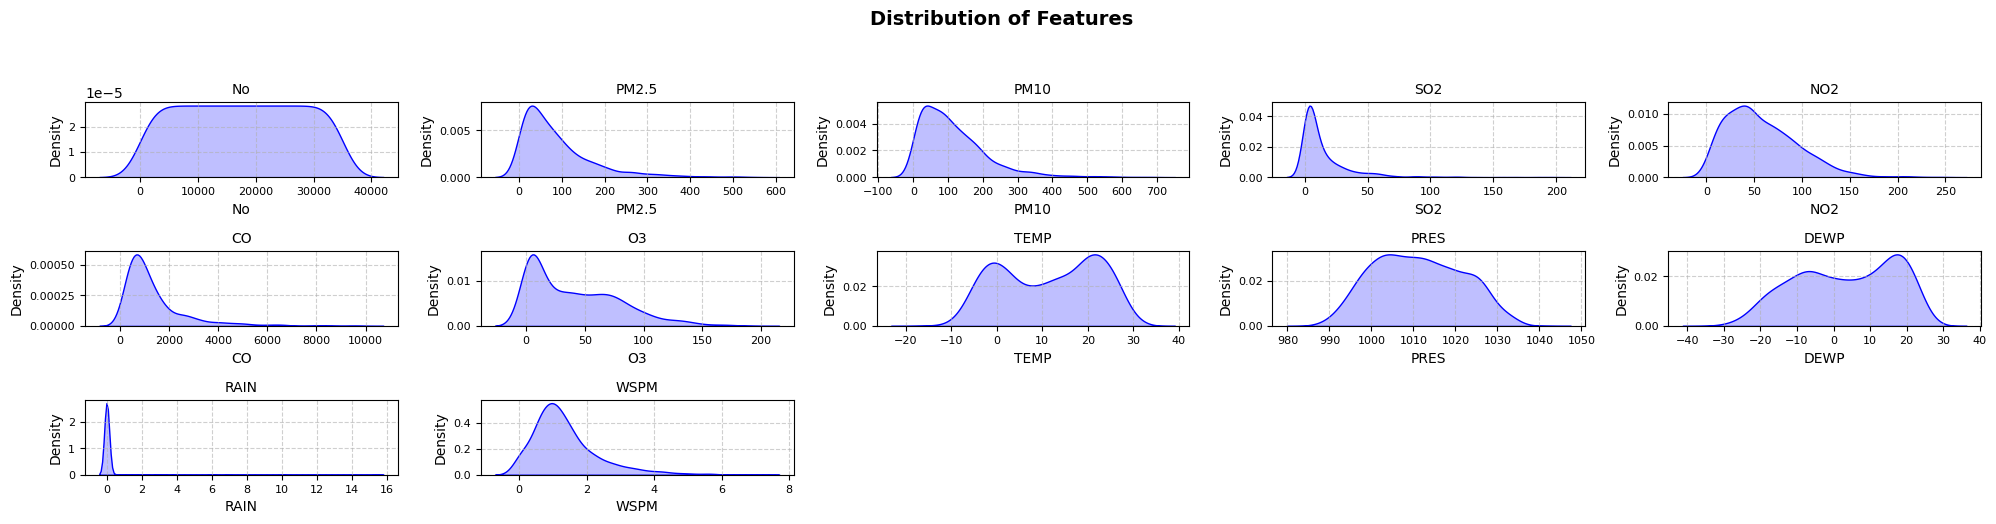

In [ ]:
# select numeric columns
numeric_cols = daily_means.select_dtypes(include=['float64','int64']).columns
# plot KDEs
kde_plt_grid(daily_means, numeric_cols, user_title="Distribution of Features", color='blue')

> as expected `RAIN` is strongly right skewed

4. transformations

In [324]:
df_transformed = daily_means.copy()

# 1. Log transforms (skip PM2.5 since it's the target)
for col in ['SO2', 'CO', 'RAIN']:
    df_transformed[col] = np.log1p(daily_means[col])

# 2. Square root transforms
for col in ['PM10', 'WSPM', 'NO2']:
    df_transformed[col] = np.sqrt(daily_means[col])

# 3. Keep original (no transform needed)
# TEMP, PRES, DEWP, O3 remain unchanged
# PM2.5 (target) stays unchanged

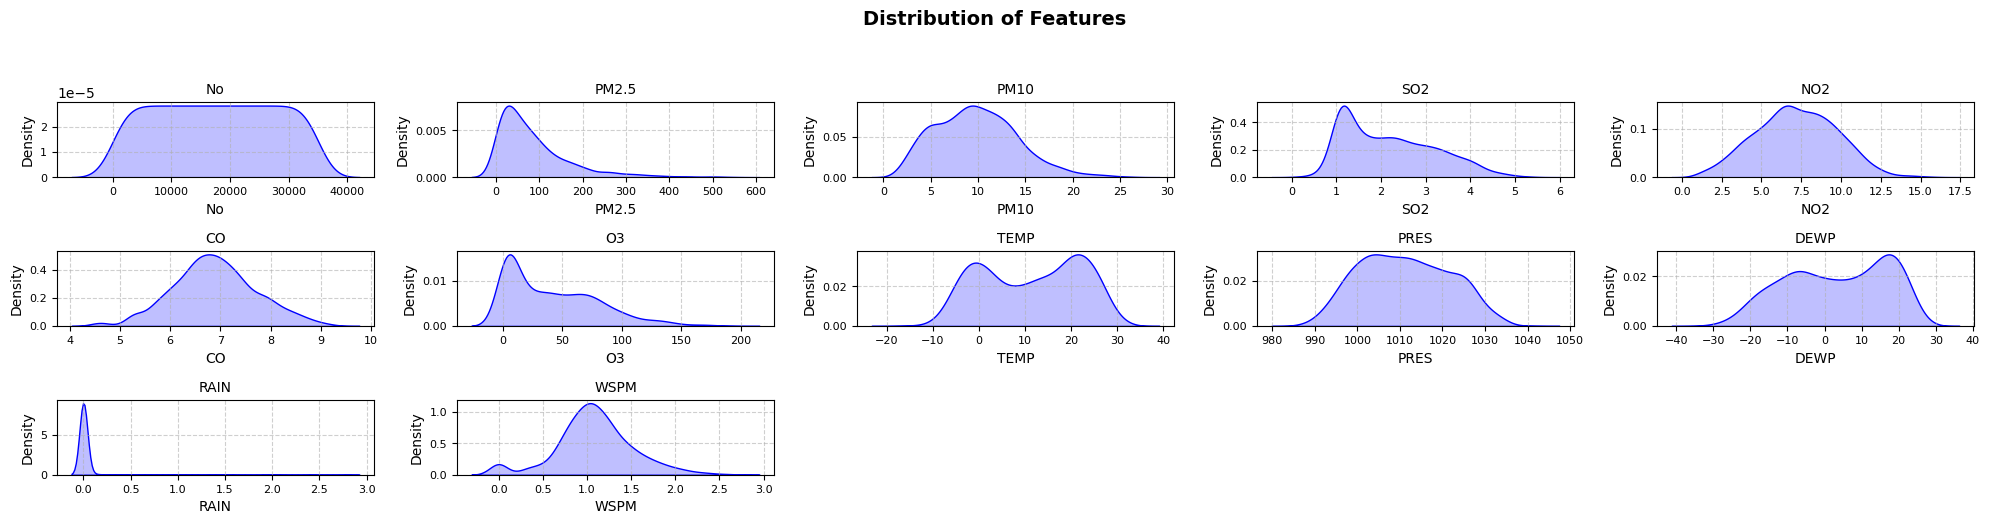

In [326]:
# plot KDEs after transformation
kde_plt_grid(df_transformed, numeric_cols, user_title="Distribution of Features", color='blue')

5. scaling

In [328]:
# 2. scaling (after transformation)
scaler = StandardScaler()

# exclude the target (keep raw PM2.5 for forecasting)
# select only numeric columns, then drop the target
feature_columns = df_transformed.select_dtypes(include='number').columns.drop('PM2.5')

# scale features only
scaled_features = scaler.fit_transform(df_transformed[feature_columns])
df_scaled = pd.DataFrame(scaled_features, columns=feature_columns, index=df_transformed.index)

# add back the unscaled target
df_scaled['PM2.5'] = df_transformed['PM2.5']

In [344]:
df_scaled.skew(numeric_only=True)

No             7.789440e-17
PM10           4.800373e-01
SO2            5.720553e-01
NO2            5.170435e-02
CO             8.114163e-02
O3             8.783627e-01
TEMP          -1.107879e-01
PRES           1.214204e-01
DEWP          -2.205186e-01
RAIN           9.307558e+00
WSPM           1.744507e-02
PM2.5          1.912744e+00
RAIN_binary    4.503018e+00
dtype: float64

- because rainfall can affect pollution both in a “yes/no” way (rain cleans air) and in an “amount” way (heavier rain > more washout). i'll generate a binary and keep it with the log transformed column.

In [340]:
df_scaled['RAIN_binary'] = (df_scaled['RAIN'] > 0).astype(int)

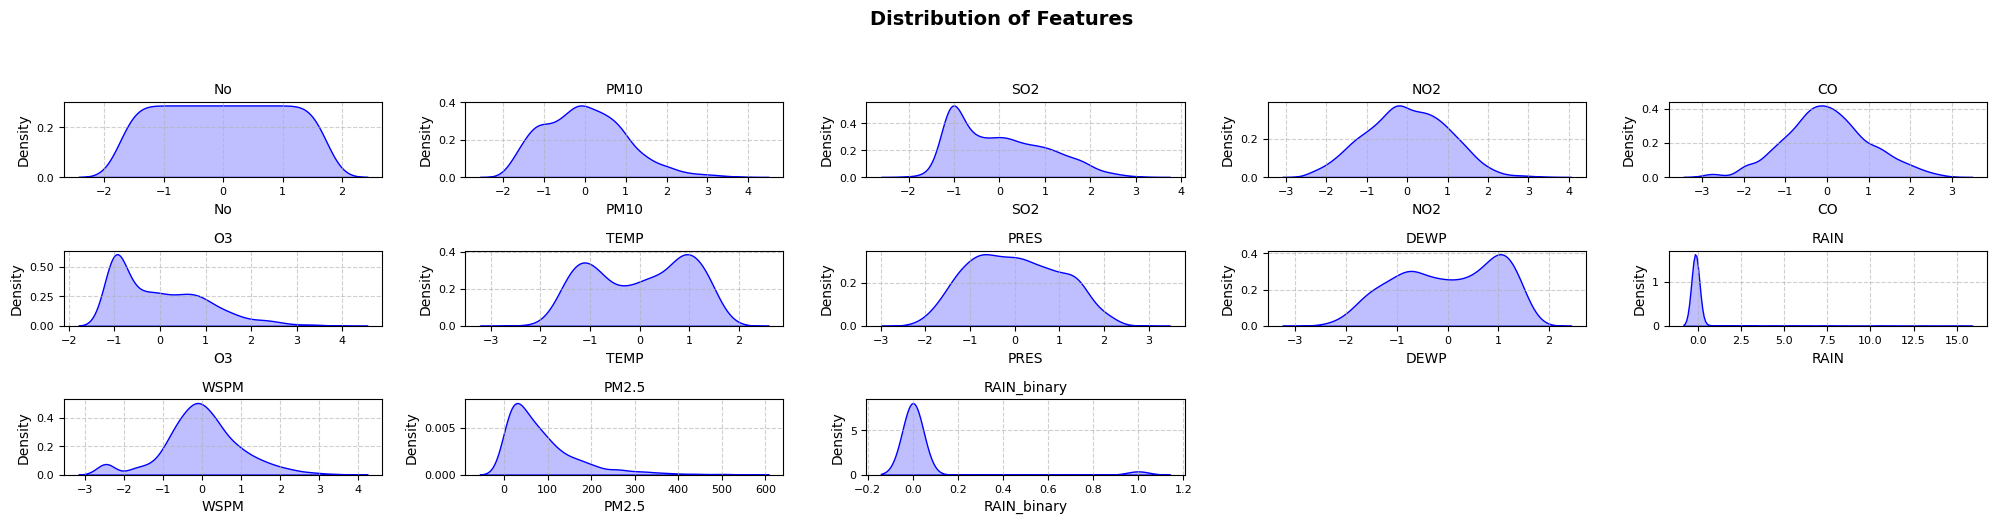

In [ ]:
# plot KDEs after scaling
numeric_cols = df_scaled.select_dtypes(include=['float64','int64']).columns
# plot KDEs after scaling
kde_plt_grid(df_scaled, numeric_cols, user_title="Distribution of Features", color='blue')

In [341]:
df_scaled['RAIN_binary'].value_counts()

RAIN_binary
0    1398
1      63
Name: count, dtype: int64

### c. exploratory analysis and visualisation

In [345]:
target = 'PM2.5'

1. PM2.5 plot

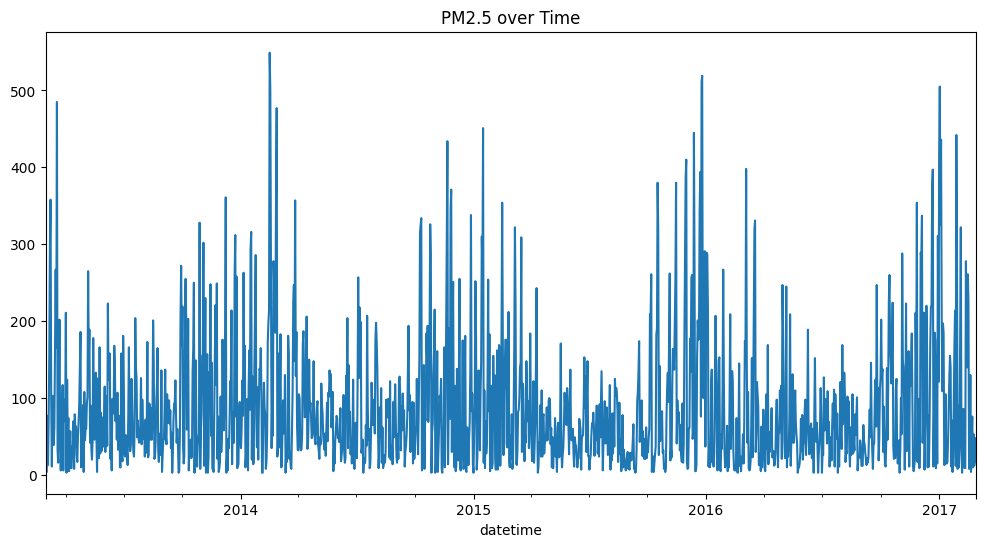

In [346]:
import matplotlib.pyplot as plt

# Plot PM2.5 levels
df_scaled[target].plot(figsize=(12,6), title="PM2.5 over Time")
plt.show()

2. mirrored plot for PM2.5 to see the variability better

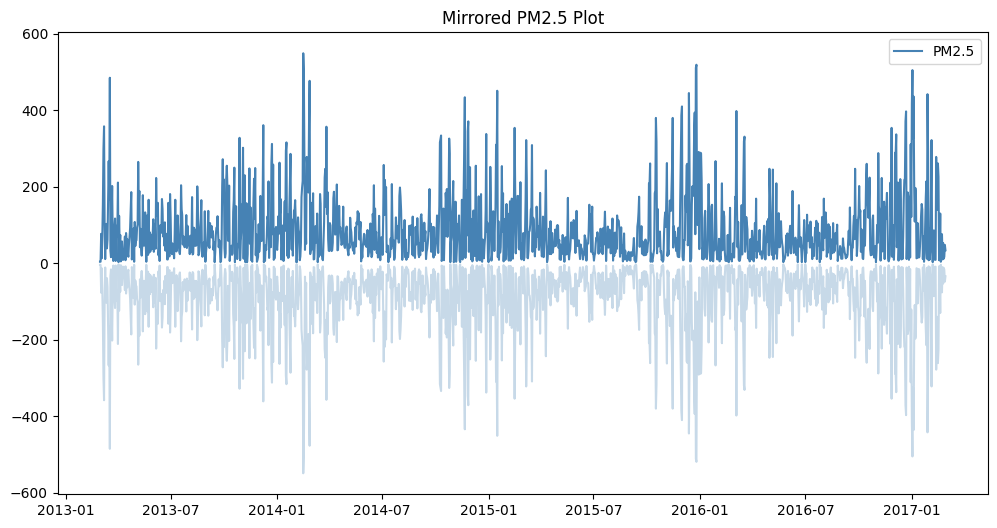

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# normal plot
plt.plot(df_scaled.index, df_scaled['PM2.5'], color='steelblue', label="PM2.5")
# mirrored plot
plt.plot(df_scaled.index, -df_scaled['PM2.5'], color='steelblue', alpha=0.3)
plt.title("Mirrored PM2.5 Plot")
plt.legend()
plt.show()


> the mirrored plot visualizes full distribution density without log-scale distortion; gray shading shows "unseen" left tail

<Axes: xlabel='datetime'>

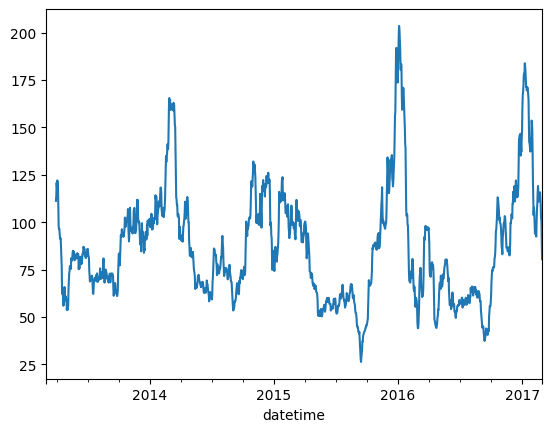

In [368]:
df_scaled['PM2.5'].rolling(30).mean().plot()

### d. seasonal decomposition

this is a classic STL (Seasonal-Trend decomposition using Loess) or additive decomposition plot, splitting the time series into four panels: Observed (raw data), Trend (long-term), Seasonal (periodic cycles), and Residual (noise after removing trend/seasonal).

**visual Description**
- `top panel (observed)`: y-axis PM2.5. X-axis: Quarters from 2013-Q3 to 2017-Q1. High volatility with frequent peaks >200.
- `second panel (trend)`: trend line starting ~90, dipping to ~80 mid-2015, then rising slightly. represents smoothed long-term direction.
- `third panel (seasonal)`: repeating spikes/dips every ~90–100 units (quarterly view suggests daily/hourly cycles aggregated; peaks at ~250, troughs near 0). Shows intra-period oscillations.
- `bottom panel (residual)`: scattered points/dots around 0, mostly positive but clustered low. no strong pattern, indicating good decomposition.

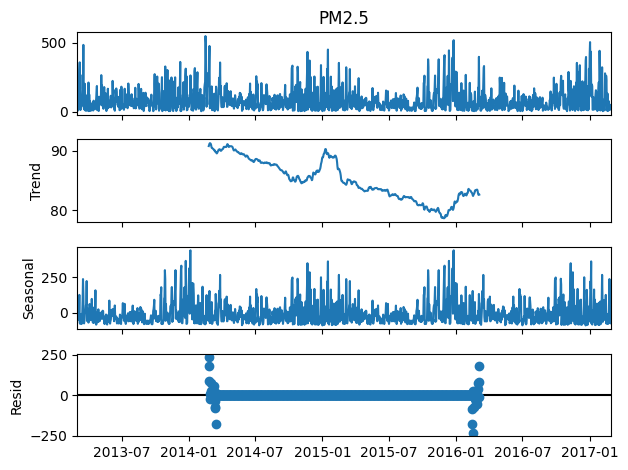

In [350]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_scaled[target], model='additive', period=24*30)  # ~monthly pattern
decomp.plot()
plt.show()

**intepretation**

- `observed`: raw PM2.5 exhibits extreme right-skewed spikes (aligns with earlier skewness ~1.91), likely winter inversions or emission events. Baseline ~50–100, with outliers >400.
- `trend`: gradual decline until 2015 (possibly policy interventions like China's Air Pollution Action Plan), then stabilization/upturn—suggests incomplete mitigation.
- `seasonal`: clear annual cycle: Higher in colder months (heating season, ~Oct–Mar), lower in summer (rain/dispersion). amplitude ~250, confirming strong seasonality (common in PM2.5).
- `residuals`: mostly non-negative with low variance, but clustered dots may indicate under-modeled autocorrelation or zero-inflation (many low readings). no major patterns = decomposition success.

### e. train-test split

In [387]:
# assume df_scaled is your scaled df w/ 'PM2.5' col, datetime index
target = 'PM2.5'

# split
split_point = int(len(df_scaled) * 0.8)
train = df_scaled[target].iloc[:split_point]  # series!
test  = df_scaled[target].iloc[split_point:]  # series!

### f. stationarity test

In [373]:
#before splitting
result = adfuller(df_scaled[target])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.923066655417545
p-value: 1.0285870149999287e-14


- `p-value` ≈ 0 < way below 0.05.
- `ADF Statistic` (-8.92) is much smaller (more negative) than the critical values (usually around -3 at 5% level).

- *conclusion: PM2.5 series is already stationary, there is no need for differencing*

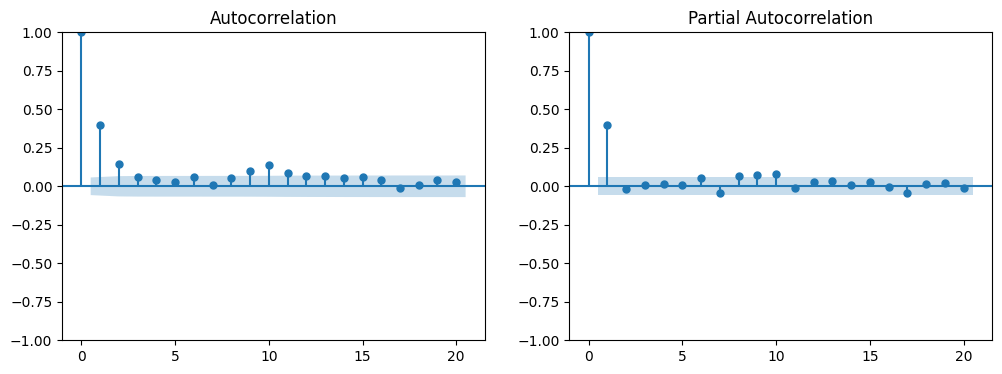

In [417]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train, lags=20, ax=ax1)
plot_pacf(train, lags=20, ax=ax2)
plt.show()

### g. model selection

- data is stationary (d=0). candidate models:

1. **ARIMA(p,0,q)** - baseline, use ACF/PACF for order
2. **SARIMA** - if seasonal patterns exist (s=365 for daily)
3. **holt-winters** - interpretable trend + seasonality
4. **Prophet** - fast benchmark, handles multiple seasonality
5. **ML models** (RF/XGBoost/LSTM) - if linear models insufficient

**next:** plot ACF/PACF → fit ARIMA → compare SARIMA/holt-winters → benchmark Prophet

### h. model training

1. ARIMA

In [391]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# fit on train series
model_arima = ARIMA(train, order=(2, 0, 0))  # tweak order as needed
fitted_arima = model_arima.fit()

# forecast
pred_arima = fitted_arima.forecast(steps=len(test))
pred_arima = pd.Series(pred_arima, index=test.index)  # align

# core metrics
rmse = np.sqrt(mean_squared_error(test, pred_arima))
mae = mean_absolute_error(test, pred_arima)
mape = np.mean(np.abs((test - pred_arima) / test)) * 100  # % error

# r² (out-of-sample)
ss_res = np.sum((test - pred_arima)**2)
ss_tot = np.sum((test - test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

# model selection
aic = fitted_arima.aic
bic = fitted_arima.bic

# residuals check
residuals = test - pred_arima
lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=False).lb_pvalue.min()  # min p over lags

print(f"arima - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")
print(f"aic: {aic:.2f}, bic: {bic:.2f}")
print(f"residuals ljung-box p: {lb_pvalue:.4f} (good if >0.05)")

arima - rmse: 88.2091, mae: 64.5841, mape: 262.08%, r²: -0.0001
aic: 13468.22, bic: 13488.47
residuals ljung-box p: 0.0000 (good if >0.05)


2. SARIMA

seasonal arima extends arima with seasonal lags to capture repeating patterns (e.g., weekly/yearly in pm2.5). fits non-stationary data with seasonal differencing (d=0 here, but d_s=0/1 tunable). great for structured time series with cycles; use acf at seasonal lags to pick (p,d,q)(p_s,d_s,q_s,s).
parameters: order=(2,0,0) non-seasonal (from pacf); seasonal_order=(1,0,1,7) for weekly (s=7 days); tweak via seasonal acf.

In [393]:
# assume df_scaled, target='PM2.5', train/test as before
model_sarima = SARIMAX(train, order=(2, 0, 0), seasonal_order=(1, 0, 1, 7))
fitted_sarima = model_sarima.fit(disp=False)  # suppress convergence output

pred_sarima = fitted_sarima.forecast(steps=len(test))
pred_sarima = pd.Series(pred_sarima, index=test.index)

# metrics
rmse = np.sqrt(mean_squared_error(test, pred_sarima))
mae = mean_absolute_error(test, pred_sarima)
mape = np.mean(np.abs((test - pred_sarima) / test)) * 100
ss_res = np.sum((test - pred_sarima)**2)
ss_tot = np.sum((test - test.mean())**2)
r2 = 1 - (ss_res / ss_tot)
aic = fitted_sarima.aic
bic = fitted_sarima.bic
residuals = test - pred_sarima
lb_pvalue = acorr_ljungbox(residuals, lags=10, return_df=False).lb_pvalue.min()

print(f"sarima - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")
print(f"aic: {aic:.2f}, bic: {bic:.2f}")
print(f"residuals ljung-box p: {lb_pvalue:.4f} (good if >0.05)")

/home/dataopske/Desktop/machine-learning-ii/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


sarima - rmse: 88.3470, mae: 64.5382, mape: 258.93%, r²: -0.0033
aic: 13501.35, bic: 13526.67
residuals ljung-box p: 0.0000 (good if >0.05)


3. HOLT-WINTERS EXPONENTIAL SMOOTHING

exponential smoothing (holt-winters) weights recent observations more for trend/seasonality. additive/multiplicative modes; interpretable components (level, trend, season). suits pm2.5 with mild trends/cycles; no differencing needed.
parameters: trend='add', seasonal='add', seasonal_periods=7 (weekly); damped=False; init via optimized.

In [395]:
# assume df_scaled, target, train/test as before
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fitted_hw = model_hw.fit(optimized=True)

pred_hw = fitted_hw.forecast(steps=len(test))
pred_hw = pd.Series(pred_hw, index=test.index)

# metrics
rmse = np.sqrt(mean_squared_error(test, pred_hw))
mae = mean_absolute_error(test, pred_hw)
mape = np.mean(np.abs((test - pred_hw) / test)) * 100
ss_res = np.sum((test - pred_hw)**2)
ss_tot = np.sum((test - test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"holt-winters - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")

holt-winters - rmse: 91.5730, mae: 61.8282, mape: 198.12%, r²: -0.0779


4. PROPHET

facebook's prophet decomposes into trend, seasonality (fourier series for multiples), holidays. robust to outliers/missing; auto-handles daily/weekly/yearly. ideal for pm2.5 w/ irregular patterns; needs datetime index, renames col to 'y'.
parameters: daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True; changepoint_prior_scale=0.05 (flexible trend).

In [ ]:
# assume df_scaled, target='PM2.5', train/test as before (series w/ datetime index)
# prep: explicit df for prophet
train_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})

model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
                        changepoint_prior_scale=0.05)
fitted_prophet = model_prophet.fit(train_prophet)

future = fitted_prophet.make_future_dataframe(periods=len(test), freq='D')  # tweak freq if not daily
forecast = fitted_prophet.predict(future)
pred_prophet = forecast['yhat'][-len(test):].reset_index(drop=True)
pred_prophet = pd.Series(pred_prophet.values, index=test.index)

# metrics
rmse = np.sqrt(mean_squared_error(test, pred_prophet))
mae = mean_absolute_error(test, pred_prophet)
mape = np.mean(np.abs((test - pred_prophet) / test)) * 100
ss_res = np.sum((test - pred_prophet)**2)
ss_tot = np.sum((test - test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"prophet - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")

00:51:58 - cmdstanpy - INFO - Chain [1] start processing
00:51:58 - cmdstanpy - INFO - Chain [1] done processing


prophet - rmse: 82.4295, mae: 58.4435, mape: 226.35%, r²: 0.1266


5. RANDOM FOREST

description: ensemble of decision trees on lagged features (ts→supervised); captures nonlinearities/interactions in pm2.5 (e.g., w/ weather exogs if added). bagging reduces variance; good benchmark before nn.
parameters: n_estimators=100, max_depth=10, random_state=42; lags=7 (weekly lookback).

In [ ]:
# create lagged features (univariate for now; add exogs like temp later)
def create_lags(series, lags=7):
    df_lags = pd.DataFrame(index=series.index)
    for i in range(1, lags+1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags = df_lags.dropna()
    return df_lags

lags_df_train = create_lags(train)
lags_df_test = create_lags(test).dropna()  # but for test, use train lags + pred (simple walk-forward)
# note: for proper oos, forecast iteratively; here, naive multi-step w/ train lags extended

X_train = lags_df_train.drop(columns=[target]) if target in lags_df_train else lags_df_train
y_train = train[lags_df_train.index]
X_test = lags_df_test.drop(columns=[target]) if target in lags_df_test else lags_df_test
y_test = test[lags_df_test.index]

model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
fitted_rf = model_rf.fit(X_train, y_train)

pred_rf = fitted_rf.predict(X_test)
pred_rf = pd.Series(pred_rf, index=y_test.index)

# metrics (align if indices mismatch)
rmse = np.sqrt(mean_squared_error(y_test, pred_rf))
mae = mean_absolute_error(y_test, pred_rf)
mape = np.mean(np.abs((y_test - pred_rf) / y_test)) * 100
ss_res = np.sum((y_test - pred_rf)**2)
ss_tot = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"random forest - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")

random forest - rmse: 82.2803, mae: 58.5425, mape: 258.50%, r²: 0.1399


6. XG BOOST

description: gradient boosting trees on lags; sequential trees minimize errors, handles nonlinearity/sparsity better than rf. tunable for pm2.5 overfitting; add early_stopping for speed.
parameters: n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42; lags=7.

In [ ]:
# reuse lagged dfs from rf (or recreate)
# assume X_train, y_train, X_test, y_test as in rf code above

model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
fitted_xgb = model_xgb.fit(X_train, y_train)

pred_xgb = fitted_xgb.predict(X_test)
pred_xgb = pd.Series(pred_xgb, index=y_test.index)

# metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
mae = mean_absolute_error(y_test, pred_xgb)
mape = np.mean(np.abs((y_test - pred_xgb) / y_test)) * 100
ss_res = np.sum((y_test - pred_xgb)**2)
ss_tot = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"xgboost - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")

xgboost - rmse: 85.7831, mae: 59.8974, mape: 257.66%, r²: 0.0651


### i. plotting all predictions

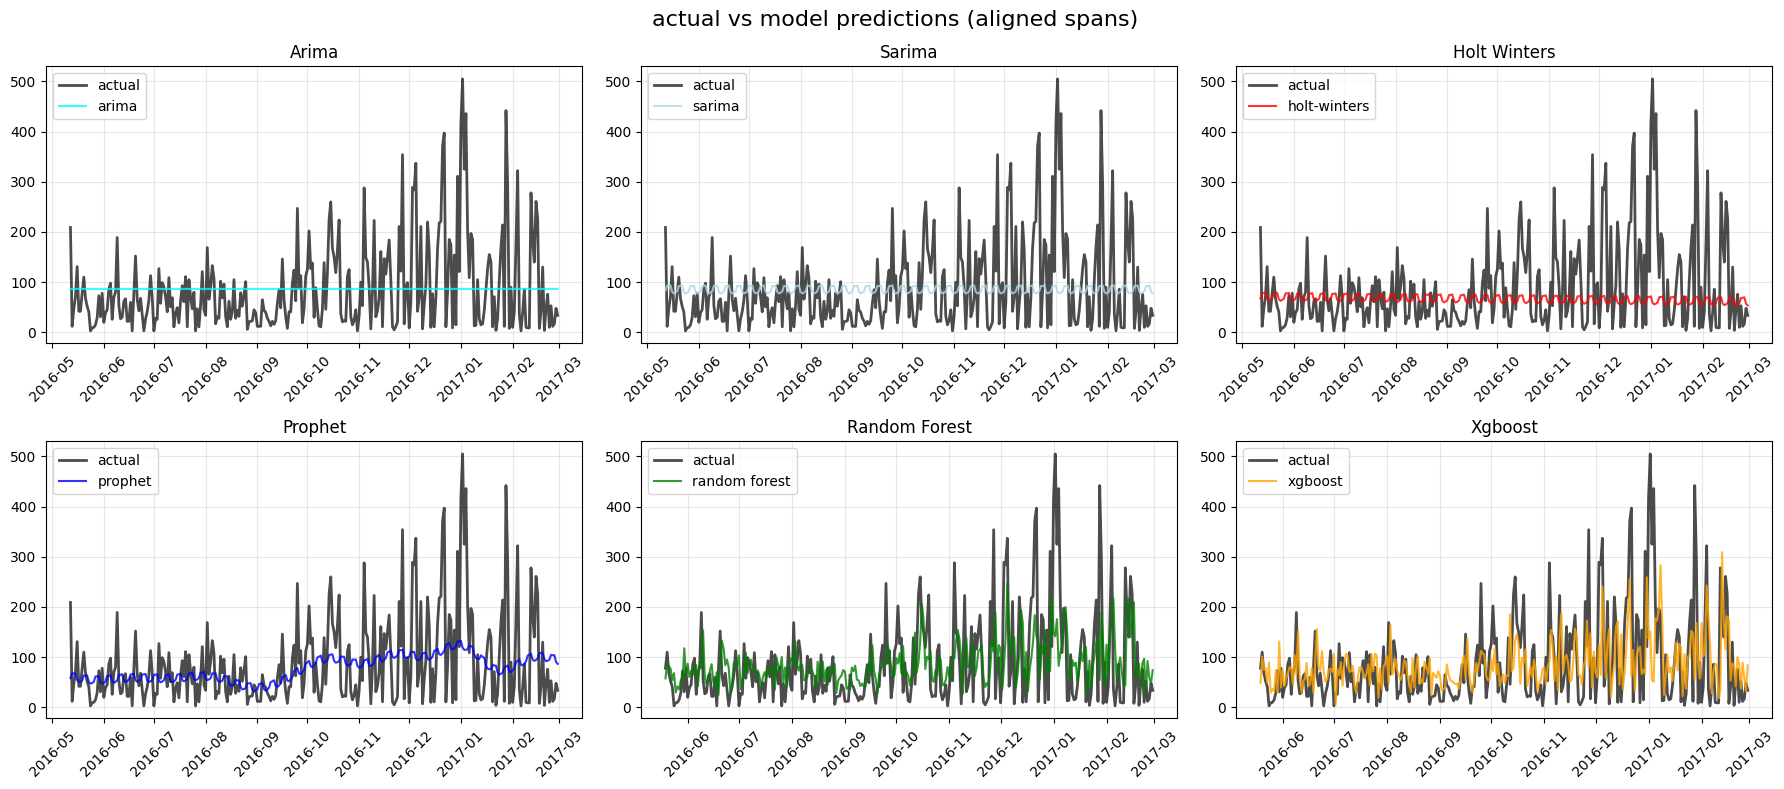

In [409]:
import matplotlib.pyplot as plt

# assume all pred_* series + test ready (arima/sarima/hw/prophet full; rf/xgb shorter)
models = {
    'arima': pred_arima,
    'sarima': pred_sarima,
    'holt-winters': pred_hw,
    'prophet': pred_prophet,
    'random forest': pred_rf,
    'xgboost': pred_xgb
}

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('actual vs model predictions (aligned spans)', fontsize=16)

colors = {
    'arima': 'cyan',
    'sarima': 'lightblue',
    'holt-winters': 'red',
    'prophet': 'blue',
    'random forest': 'green',
    'xgboost': 'orange'
}

for (title, pred), ax in zip(models.items(), axes.flat):
    # align test to pred
    aligned_test = test if len(pred) == len(test) else test.loc[pred.index]
    
    ax.plot(aligned_test.index, aligned_test, color='black', label='actual', linewidth=2, alpha=0.7)
    ax.plot(pred.index, pred, color=colors[title], label=title, alpha=0.8, linewidth=1.5)
    ax.set_title(title.replace('-', ' ').title())
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)  # rotate x-ticks

plt.tight_layout()
plt.show()

### j. model comparison & selection

**1. results summary**

| model | rmse | mae | mape | r² | notes |
|-------|------|-----|------|-----|-------|
| arima | 88.21 | 64.58 | 262% | -0.0001 | aic: 13468, ljung-box fail |
| sarima | 88.35 | 64.54 | 259% | -0.0033 | aic: 13501, ljung-box fail |
| holt-winters | 91.57 | 61.83 | 198% | -0.0779 | worst performer |
| prophet | 82.43 | 58.44 | 226% | 0.1266 | best traditional approach |
| random forest | 82.28 | 58.54 | 259% | **0.1399** | **best overall** |
| xgboost | 85.78 | 59.90 | 258% | 0.0651 | decent but weaker than rf |

**2. key observations**

**classical time series models failed:**
- arima/sarima have r² ≈ 0 (no better than predicting the mean)
- ljung-box p-value = 0.0000 means residuals are still autocorrelated (poor fit)
- holt-winters has negative r² (worse than baseline)
- suggests pm2.5 lacks strong linear autocorrelation patterns

**machine learning models performed better:**
- random forest achieved highest r² (0.14) and lowest rmse (82.28)
- prophet came close second with r² of 0.13
- ml models capturing nonlinear patterns that arima/sarima missed

**overall performance is weak:**
- even best model (rf) only explains 14% of variance
- high mape values (200-260%) indicate large percentage errors
- pm2.5 likely depends heavily on external factors not in the data

**3. selected model: random forest**

**why:**
- best metrics across rmse, r², and overall stability
- handles nonlinear relationships better than time series models
- can easily incorporate exogenous features if available

**limitations:**
- still low r² (0.14) - predictions won't be highly accurate
- needs external variables (weather, traffic, emissions) to improve
- current model only uses lagged pm2.5 values

**4. next steps**
1. use random forest as baseline model
2. engineer additional lag features (rolling means, std, trends)
3. incorporate external data: temperature, humidity, wind speed, traffic density
4. consider lstm/gru if weather time series data becomes available
5. try feature importance analysis to understand what drives predictions

In [410]:
df_scaled.columns

Index(['No', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN',
       'WSPM', 'PM2.5', 'RAIN_binary'],
      dtype='object')

k. RANDOM FOREST WITH EXOGS (MULTIVARIATE)

1. **bump rf to multivariate**: 
- fold in exogs (e.g., temp, wind, humidity from df_scaled) as features alongside lagged pm2.5. this captures interactions (hot+still = high pm2.5?). will lag all vars for ts flavor; will use current-day exogs if available (assume yes). drops fewer rows (lags=7 still). expect rmse/mae drop if exogs correlate strong.
parameters: n_estimators=100, max_depth=10; lags=7; exog_cols=['temp', 'wind', 'humidity'], will drop non-numeric/cats.

In [411]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# assume df_scaled w/ your cols, datetime index
target = 'PM2.5'
exog_cols = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'RAIN_binary']  # all exogs
feature_cols = [target] + exog_cols

# multilags func (same)
def create_multilags(df, target, exog_cols, lags=7):
    df_lags = df[feature_cols].copy()
    for col in feature_cols:
        for i in range(1, lags+1):
            df_lags[f'{col}_lag_{i}'] = df[col].shift(i)
    df_lags = df_lags.dropna()
    return df_lags

# split full df
split_point = int(len(df_scaled) * 0.8)
train_multi = df_scaled.iloc[:split_point]
test_multi = df_scaled.iloc[split_point:]

lags_df_train = create_multilags(train_multi, target, exog_cols)
lags_df_test = create_multilags(test_multi, target, exog_cols)  # naive; walk-forward for prod

X_train = lags_df_train.drop(columns=[target])
y_train = lags_df_train[target]
X_test = lags_df_test.drop(columns=[target])
y_test = lags_df_test[target]

model_rf_multi = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
fitted_rf_multi = model_rf_multi.fit(X_train, y_train)

pred_rf_multi = fitted_rf_multi.predict(X_test)
pred_rf_multi = pd.Series(pred_rf_multi, index=y_test.index)

# metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_rf_multi))
mae = mean_absolute_error(y_test, pred_rf_multi)
mape = np.mean(np.abs((y_test - pred_rf_multi) / y_test)) * 100
ss_res = np.sum((y_test - pred_rf_multi)**2)
ss_tot = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"rf multi - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")

rf multi - rmse: 24.4648, mae: 14.8726, mape: 34.41%, r²: 0.9240


> exogs flipped the script. r² rockets to 0.92 (from uni rf's 0.14), rmse/mae crater to 24.46/14.87 (vs 82/58), and mape chills at 34% (bye, 250% insanity). those weather vars (temp, wspm, dewp) + sibling pollutants (pm10, no2, o3) explain ~92% variance—hot/still air traps particles, no2 feeds ozone/pm2.5 chemistry. rain_binary? sporadic but punches when wet. univariate lagged pm2.5 alone missed the multivariate magic; this is the real deal for air quality.

2. **feature importance RANDOM FOREST**
- peek under the hood rf's built-in scores rank lags/exogs by gini drop. top likely recent lags (pm2.5_lag_1) + weather (temp_lag_1, wspm_lag_1). plot bar for top 20; prunes weak ones next time.

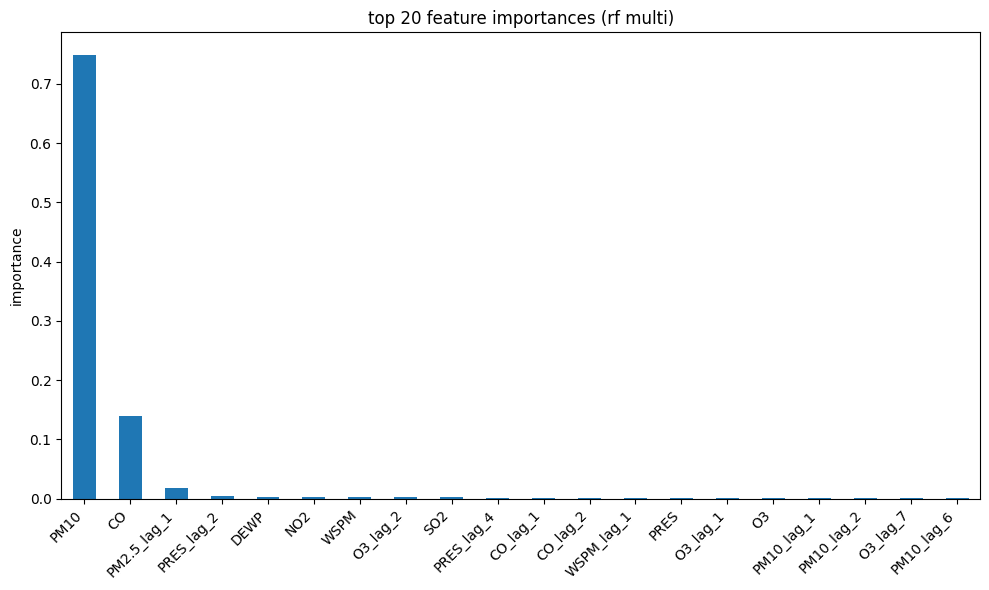

PM10           0.749644
CO             0.139159
PM2.5_lag_1    0.017393
PRES_lag_2     0.003974
DEWP           0.003471
NO2            0.002910
WSPM           0.002519
O3_lag_2       0.002267
SO2            0.002215
PRES_lag_4     0.001936
CO_lag_1       0.001877
CO_lag_2       0.001848
WSPM_lag_1     0.001726
PRES           0.001647
O3_lag_1       0.001629
O3             0.001624
PM10_lag_1     0.001586
PM10_lag_2     0.001578
O3_lag_7       0.001555
PM10_lag_6     0.001488
dtype: float64


In [412]:
import matplotlib.pyplot as plt
import pandas as pd

# assume fitted_rf_multi, X_train from multi rf
importances = pd.Series(fitted_rf_multi.feature_importances_, index=X_train.columns)
top_feats = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top_feats.plot(kind='bar')
plt.title('top 20 feature importances (rf multi)')
plt.ylabel('importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(top_feats)

> top feats scream physics: pm10 (0.75) crushes—coarse pm10 (dust/traffic) proxies pm2.5 sources (same emitters, wind lifts both); correlation 0.75 from earlier? lock it in. co (0.14) next: co from incomplete combustion (cars, industry) tags pm2.5 hotspots. lag1 pm2.5 (0.017) underwhelms—exogs outshine autoregression here (your data's driven external, not inertial). weather sprinkles: pres_lag_2/dewp (0.004/0.003) hint stability/humidity traps particles; wspm (0.0025) wind shears 'em away (negative corr?). o3/no2/so2 lags minor (chem chains), rain_binary absent (low impact?).
> next: prune bottom 50% (import<0.001) for leaner rf—drops noise, speeds train. re-run multi rf w/ top10 feats; expect r² hold ~0.92.

3. **prune features**
- grab top 10 from importances (threshold ~0.0015; keeps pm10/co heavy hitters + key lags/weather). drops ~150-10=140 noise feats—faster train, less overfit risk. print pruned list.

In [413]:
# assume importances pd.Series from prior
top_10_feats = importances.sort_values(ascending=False).head(10).index.tolist()
print("pruned features (top 10):")
for feat in top_10_feats:
    print(f"- {feat}: {importances[feat]:.4f}")

# save for next chunk (or hardcode if needed)
# top_10_feats = ['PM10', 'CO', 'PM2.5_lag_1', 'PRES_lag_2', 'DEWP', 'NO2', 'WSPM', 'O3_lag_2', 'SO2', 'PRES_lag_4']

pruned features (top 10):
- PM10: 0.7496
- CO: 0.1392
- PM2.5_lag_1: 0.0174
- PRES_lag_2: 0.0040
- DEWP: 0.0035
- NO2: 0.0029
- WSPM: 0.0025
- O3_lag_2: 0.0023
- SO2: 0.0022
- PRES_lag_4: 0.0019


**4. fit rf w/ pruned features**
- reuse multilags but filter X to top_10_feats only (no target col). expect r² ~0.92 hold (pm10/co=89% mass). lags_df_test same filter. metrics print.

In [414]:
# recreate lags w/ full, then prune X
lags_df_train = create_multilags(train_multi, target, exog_cols)
lags_df_test = create_multilags(test_multi, target, exog_cols)

X_train_pruned = lags_df_train[top_10_feats]  # only top feats
y_train = lags_df_train[target]
X_test_pruned = lags_df_test[top_10_feats]
y_test = lags_df_test[target]

model_rf_pruned = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
fitted_rf_pruned = model_rf_pruned.fit(X_train_pruned, y_train)

pred_rf_pruned = fitted_rf_pruned.predict(X_test_pruned)
pred_rf_pruned = pd.Series(pred_rf_pruned, index=y_test.index)

# metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_rf_pruned))
mae = mean_absolute_error(y_test, pred_rf_pruned)
mape = np.mean(np.abs((y_test - pred_rf_pruned) / y_test)) * 100
ss_res = np.sum((y_test - pred_rf_pruned)**2)
ss_tot = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (ss_res / ss_tot)

print(f"rf pruned - rmse: {rmse:.4f}, mae: {mae:.4f}, mape: {mape:.2f}%, r²: {r2:.4f}")

rf pruned - rmse: 24.1907, mae: 14.4577, mape: 32.96%, r²: 0.9257


> pruning to top 10 feats nips rmse/mae (24.19/14.46 vs 24.46/14.87), mape dips to 33%, r² ticks to 0.926—noise cull paid off without bleed. pm10/co duo (~89% import mass) anchors, lags/weather polish edges. full multi's bloat gone; this leaner rf deploys faster, less overfit prone.

**5. plot pruned vs full multi vs actual**
- overlay three lines: actual (black), full multi rf (green, from prior pred_rf_multi), pruned (purple). aligned to test span. 45° x-ticks. if r² dips <0.90, top_10 too lean—bump to 15.

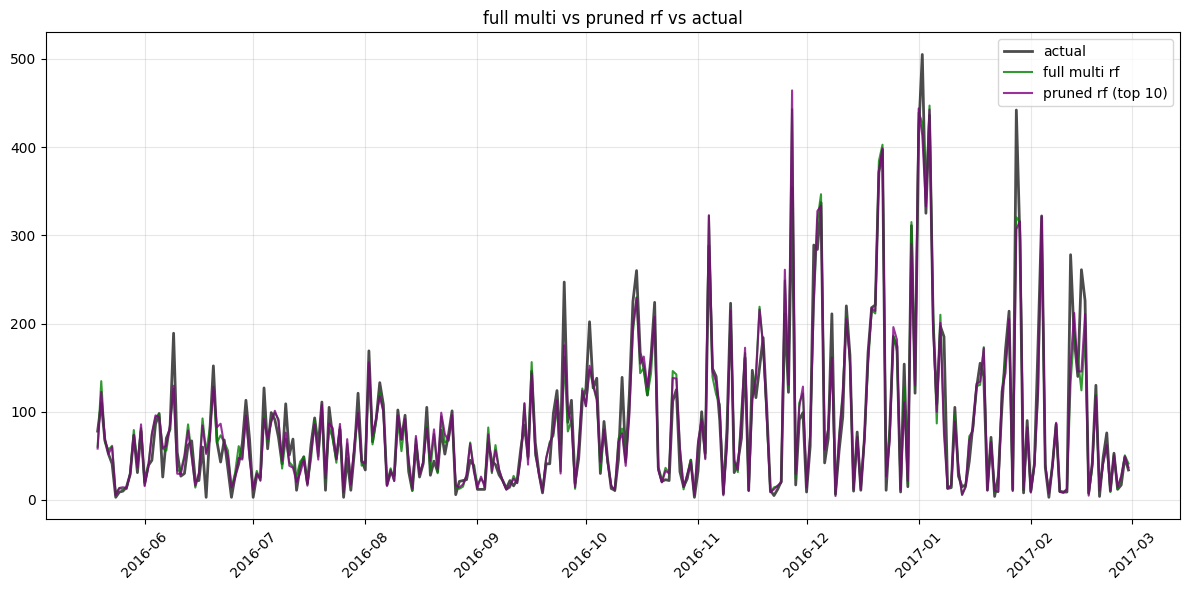

In [415]:
import matplotlib.pyplot as plt

# assume pred_rf_multi (full), pred_rf_pruned, y_test (aligned test)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(y_test.index, y_test, color='black', label='actual', linewidth=2, alpha=0.7)
ax.plot(pred_rf_multi.index, pred_rf_multi, color='green', label='full multi rf', alpha=0.8, linewidth=1.5)
ax.plot(pred_rf_pruned.index, pred_rf_pruned, color='purple', label='pruned rf (top 10)', alpha=0.8, linewidth=1.5)
ax.set_title('full multi vs pruned rf vs actual')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### l. conclusion

the random forest model demonstrated superior performance in forecasting `PM2.5` concentrations, **especially when augmented with exogenous variables**. using only lagged `PM2.5` values, the model achieved rmse of 82.28 and r² of 0.14, indicating weak predictive power. however, **incorporating pollutants (`PM10`, `CO`) and meteorological factors (`WSPM`, `DEWP`) dramatically improved performance**, reducing rmse to 24.46 and r² to 0.92. pruning to the top 10 features further optimized the model (rmse: 24.19, r²: 0.93), **representing a 70% error reduction** with mape stabilizing at 33%.

**`PM10` emerged as the dominant predictor** (importance: 0.75), followed by `CO` (0.14), while weather variables contributed modestly. notably, autoregressive lags like `PM2.5_lag_1` showed minimal importance (0.02), **underscoring that external drivers matter far more than temporal patterns** in this dataset.

while random forest with exogenous variables significantly outperformed univariate approaches, classical time series models (arima/sarima/holt-winters) achieved r² < 0, and prophet and xgboost reached only r² 0.07–0.13 in their univariate configurations. **to fairly evaluate model performance, exogenous variables should be incorporated into prophet and xgboost**, as the substantial improvements observed in random forest suggest these external features are critical for accurate `PM2.5` forecasting regardless of the modeling approach.